In [24]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

## The bias correction is apply only on the RSR products, for Ensemble the correction is created using the corrected RSR values

In [25]:
correction, nameout = 'quantile-quantile', 'QQc'
# correction, nameout = 'linear-regression', 'LRc'
print(f'Correction method: {correction}')

Correction method: quantile-quantile


In [26]:
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CMORPH', '3h'
product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CHIRPS', '1dy'
# product, time_reso = 'GSMaP', '3h'

In [27]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

In [28]:
COMPUTERNAME = os.environ['COMPUTERNAME']
print(f'Computer: {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

Computer: UNIPD_DELL


In [29]:
veneto_dir = os.path.join(dir_font,'media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [30]:
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')
weibul_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC','Weibull','1dy')

sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

In [31]:
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [32]:
seed = 23
frac = 0.7

ISO_list = METADATA.ISO.unique()

Q_80_list = []
Q_20_list = []

for iso in METADATA['ISO'].unique():
    
    META_iso = METADATA[METADATA['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_80_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_80_list.append(META_80)
    Q_20_list.append(META_20)

Q_80 = pd.concat(Q_80_list, ignore_index=True)
Q_20 = pd.concat(Q_20_list, ignore_index=True)

print(f'Number of Stations: {len(METADATA)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 2943
80% DataFrame: 2058
20% DataFrame: 885


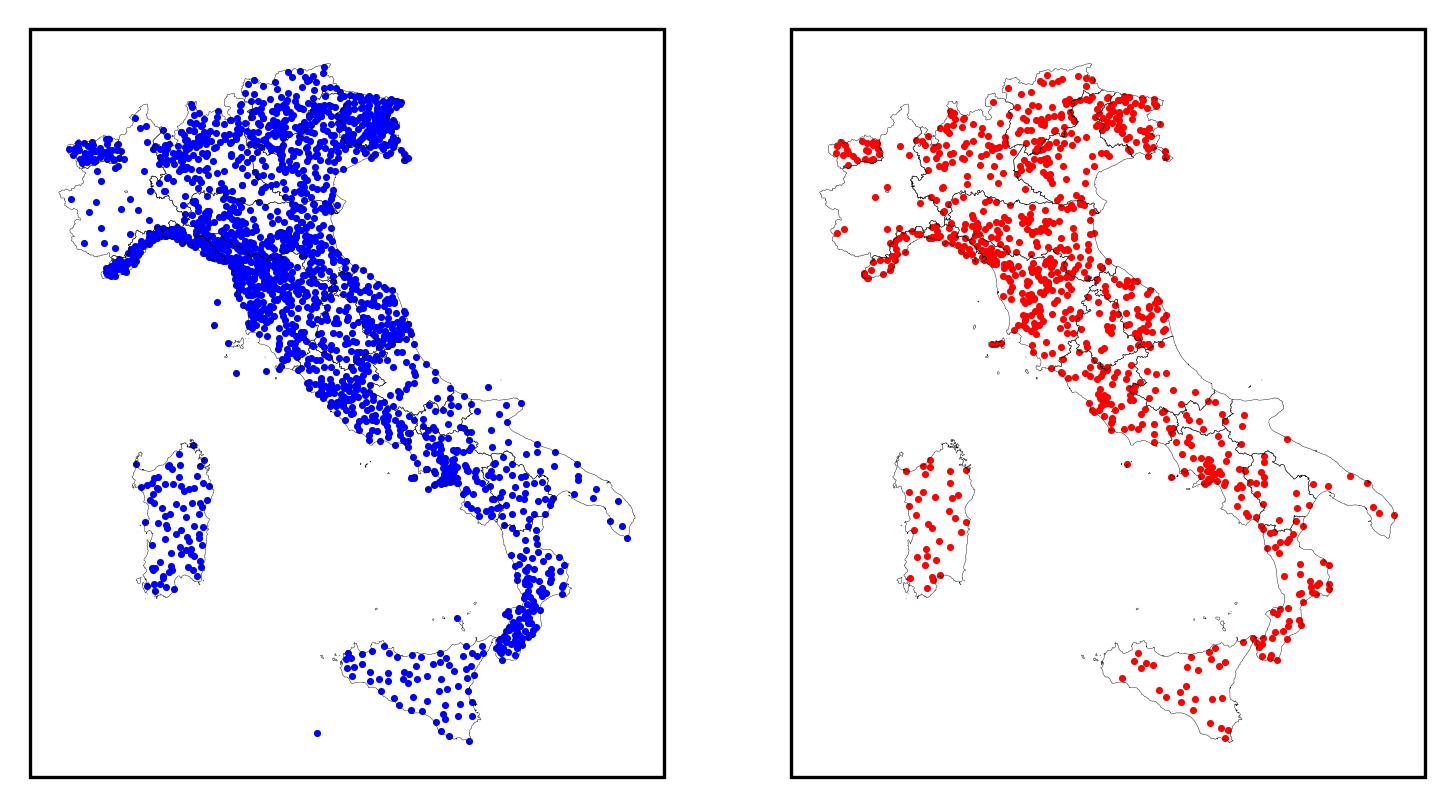

In [33]:
elev_cmap = plt.cm.Spectral_r

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# =============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
a1 = ax1.scatter(Q_80['Lon'],Q_80['Lat'],c='b',s=0.5)

# =============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
a1 = ax1.scatter(Q_20['Lon'],Q_20['Lat'],c='r',s=0.5)

In [34]:
print(f'Load {product}')
dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')

print(f'Reading: {dir_in.split('/')[-1]}')
DATA = xr.open_dataset(dir_in)

lats = DATA.lat
lons = DATA.lon
lon2d, lat2d = np.meshgrid(lons, lats)

Sat_year = DATA.year.values

NYs = DATA.NYs.values
CYs = DATA.CYs.values
WYs = DATA.WYs.values

NYd = DATA.NYd.values
CYd = DATA.CYd.values
WYd = DATA.WYd.values

ntime, nlat, nlon = NYd.shape

Load ERA5
Reading: ITALY_DOWN_ERA5_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [35]:
N_obs, C_obs, W_obs = [], [], []
for nn in range(len(Q_80)):
    file_ = os.path.join(weibul_base, Q_80.ISO[nn], Q_80.File[nn])
    statistic = pd.read_csv(file_)
    statistic = statistic[(statistic['Year']>=2002)&(statistic['Year']<=2023)].reset_index(drop=True)
    N_obs.extend(statistic.N.values)
    C_obs.extend(statistic.C.values)
    W_obs.extend(statistic.W.values)

In [ ]:
print(f'Applying {correction} bias correction')

if correction == 'quantile-quantile':
    NYd_corrected = ART_sta.ISIMIP_QM(N_obs, NYd.flatten())
    CYd_corrected = ART_sta.ISIMIP_QM(C_obs, CYd.flatten())
    WYd_corrected = ART_sta.ISIMIP_QM(W_obs, WYd.flatten())

    NYs_corrected = ART_sta.ISIMIP_QM(N_obs, NYs.flatten())
    CYs_corrected = ART_sta.ISIMIP_QM(C_obs, CYs.flatten())
    WYs_corrected = ART_sta.ISIMIP_QM(W_obs, WYs.flatten())

elif correction == 'linear-regression':
    NYd_corrected = ART_sta.bias_correction_linear_regression(N_obs, NYd.flatten())
    CYd_corrected = ART_sta.bias_correction_linear_regression(C_obs, CYd.flatten())
    WYd_corrected = ART_sta.bias_correction_linear_regression(W_obs, WYd.flatten())

    NYs_corrected = ART_sta.bias_correction_linear_regression(N_obs, NYs.flatten())
    CYs_corrected = ART_sta.bias_correction_linear_regression(C_obs, CYs.flatten())
    WYs_corrected = ART_sta.bias_correction_linear_regression(W_obs, WYs.flatten())

else:
    print('No correction applied')

Applying quantile-quantile bias correction


In [ ]:
NYd_corrected = NYd_corrected.reshape(ntime, nlat, nlon)
CYd_corrected = CYd_corrected.reshape(ntime, nlat, nlon)
WYd_corrected = WYd_corrected.reshape(ntime, nlat, nlon)

NYs_corrected = NYs_corrected.reshape(ntime, nlat, nlon)
CYs_corrected = CYs_corrected.reshape(ntime, nlat, nlon)
WYs_corrected = WYs_corrected.reshape(ntime, nlat, nlon)

Text(0.0, 1.0, 'Down Weibull Scale Parameter')

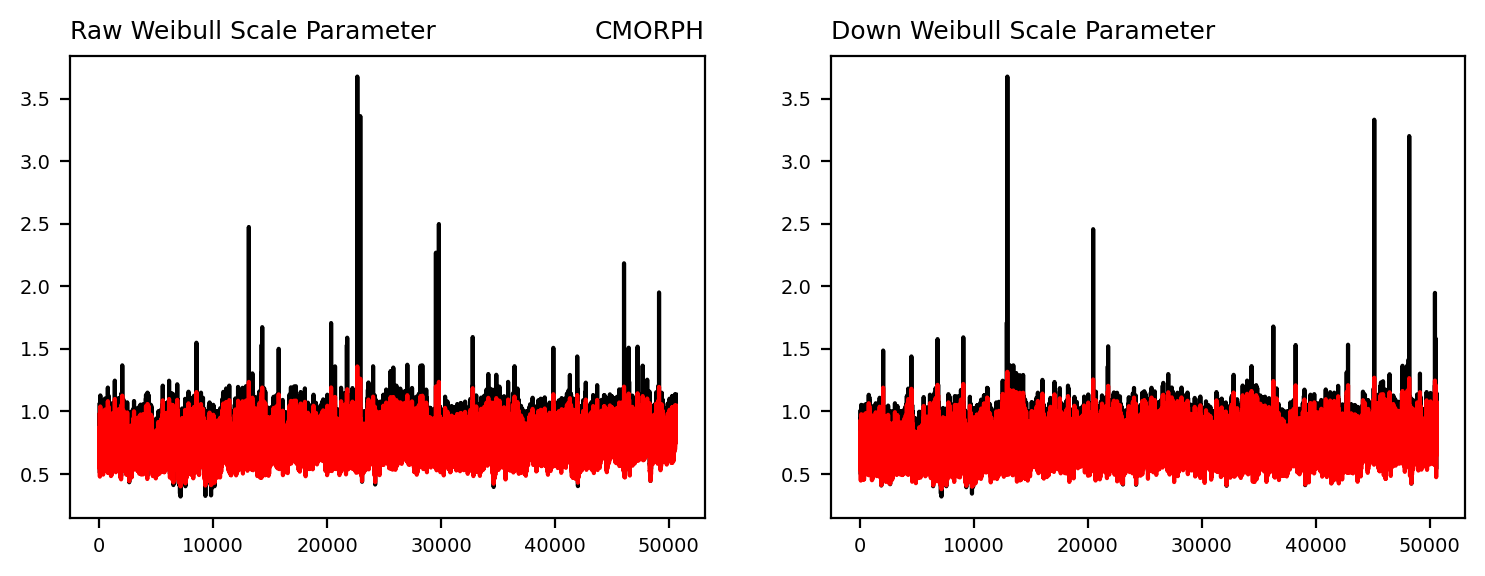

In [ ]:
fig = plt.figure(figsize=(9,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(WYs_corrected.flatten(),'k')
ax1.plot(WYs.flatten(),'r')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Raw Weibull Scale Parameter', fontsize=9, loc='left')
ax1.set_title(f'{product}', fontsize=9, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(WYd_corrected.flatten(),'k')
ax1.plot(WYd.flatten(),'r')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Down Weibull Scale Parameter', fontsize=9, loc='left')

In [ ]:
WYs_corrected = np.where(WYs_corrected>1.6,1.6,WYs_corrected)
WYd_corrected = np.where(WYd_corrected>1.6,1.6,WYd_corrected)

Text(0.0, 1.0, 'Down Weibull Scale Parameter')

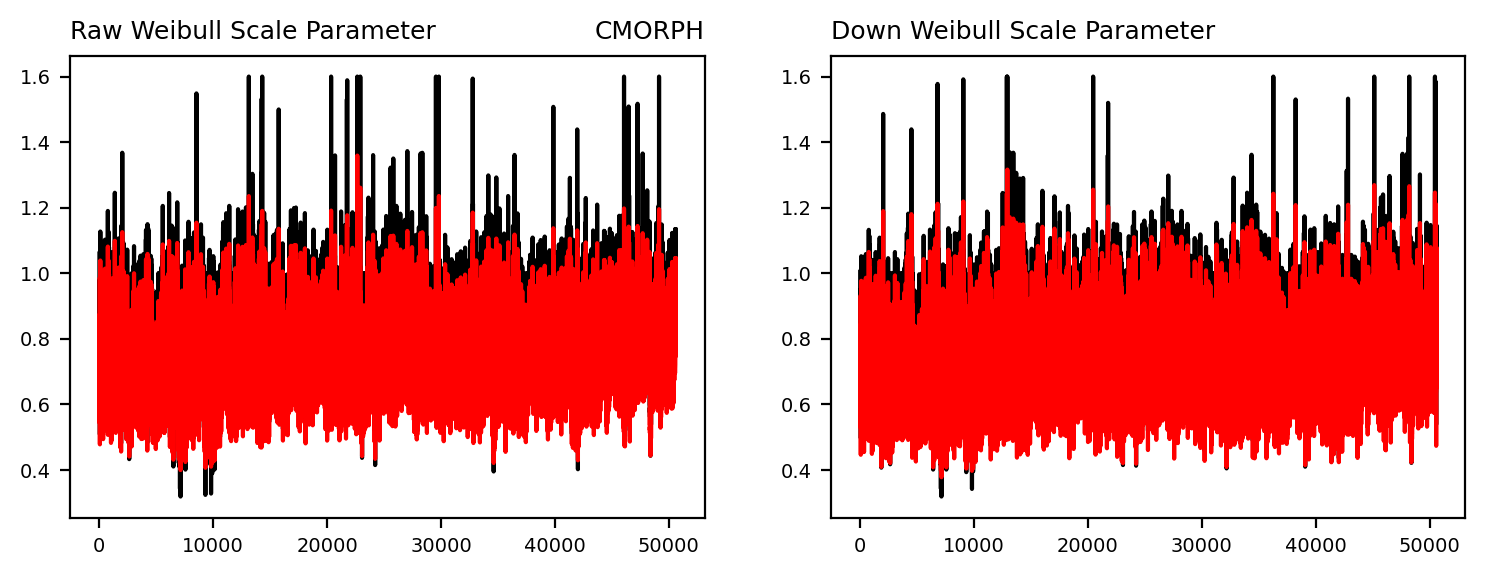

In [ ]:
fig = plt.figure(figsize=(9,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(WYs_corrected.flatten(),'k')
ax1.plot(WYs.flatten(),'r')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Raw Weibull Scale Parameter', fontsize=9, loc='left')
ax1.set_title(f'{product}', fontsize=9, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(WYd_corrected.flatten(),'k')
ax1.plot(WYd.flatten(),'r')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Down Weibull Scale Parameter', fontsize=9, loc='left')

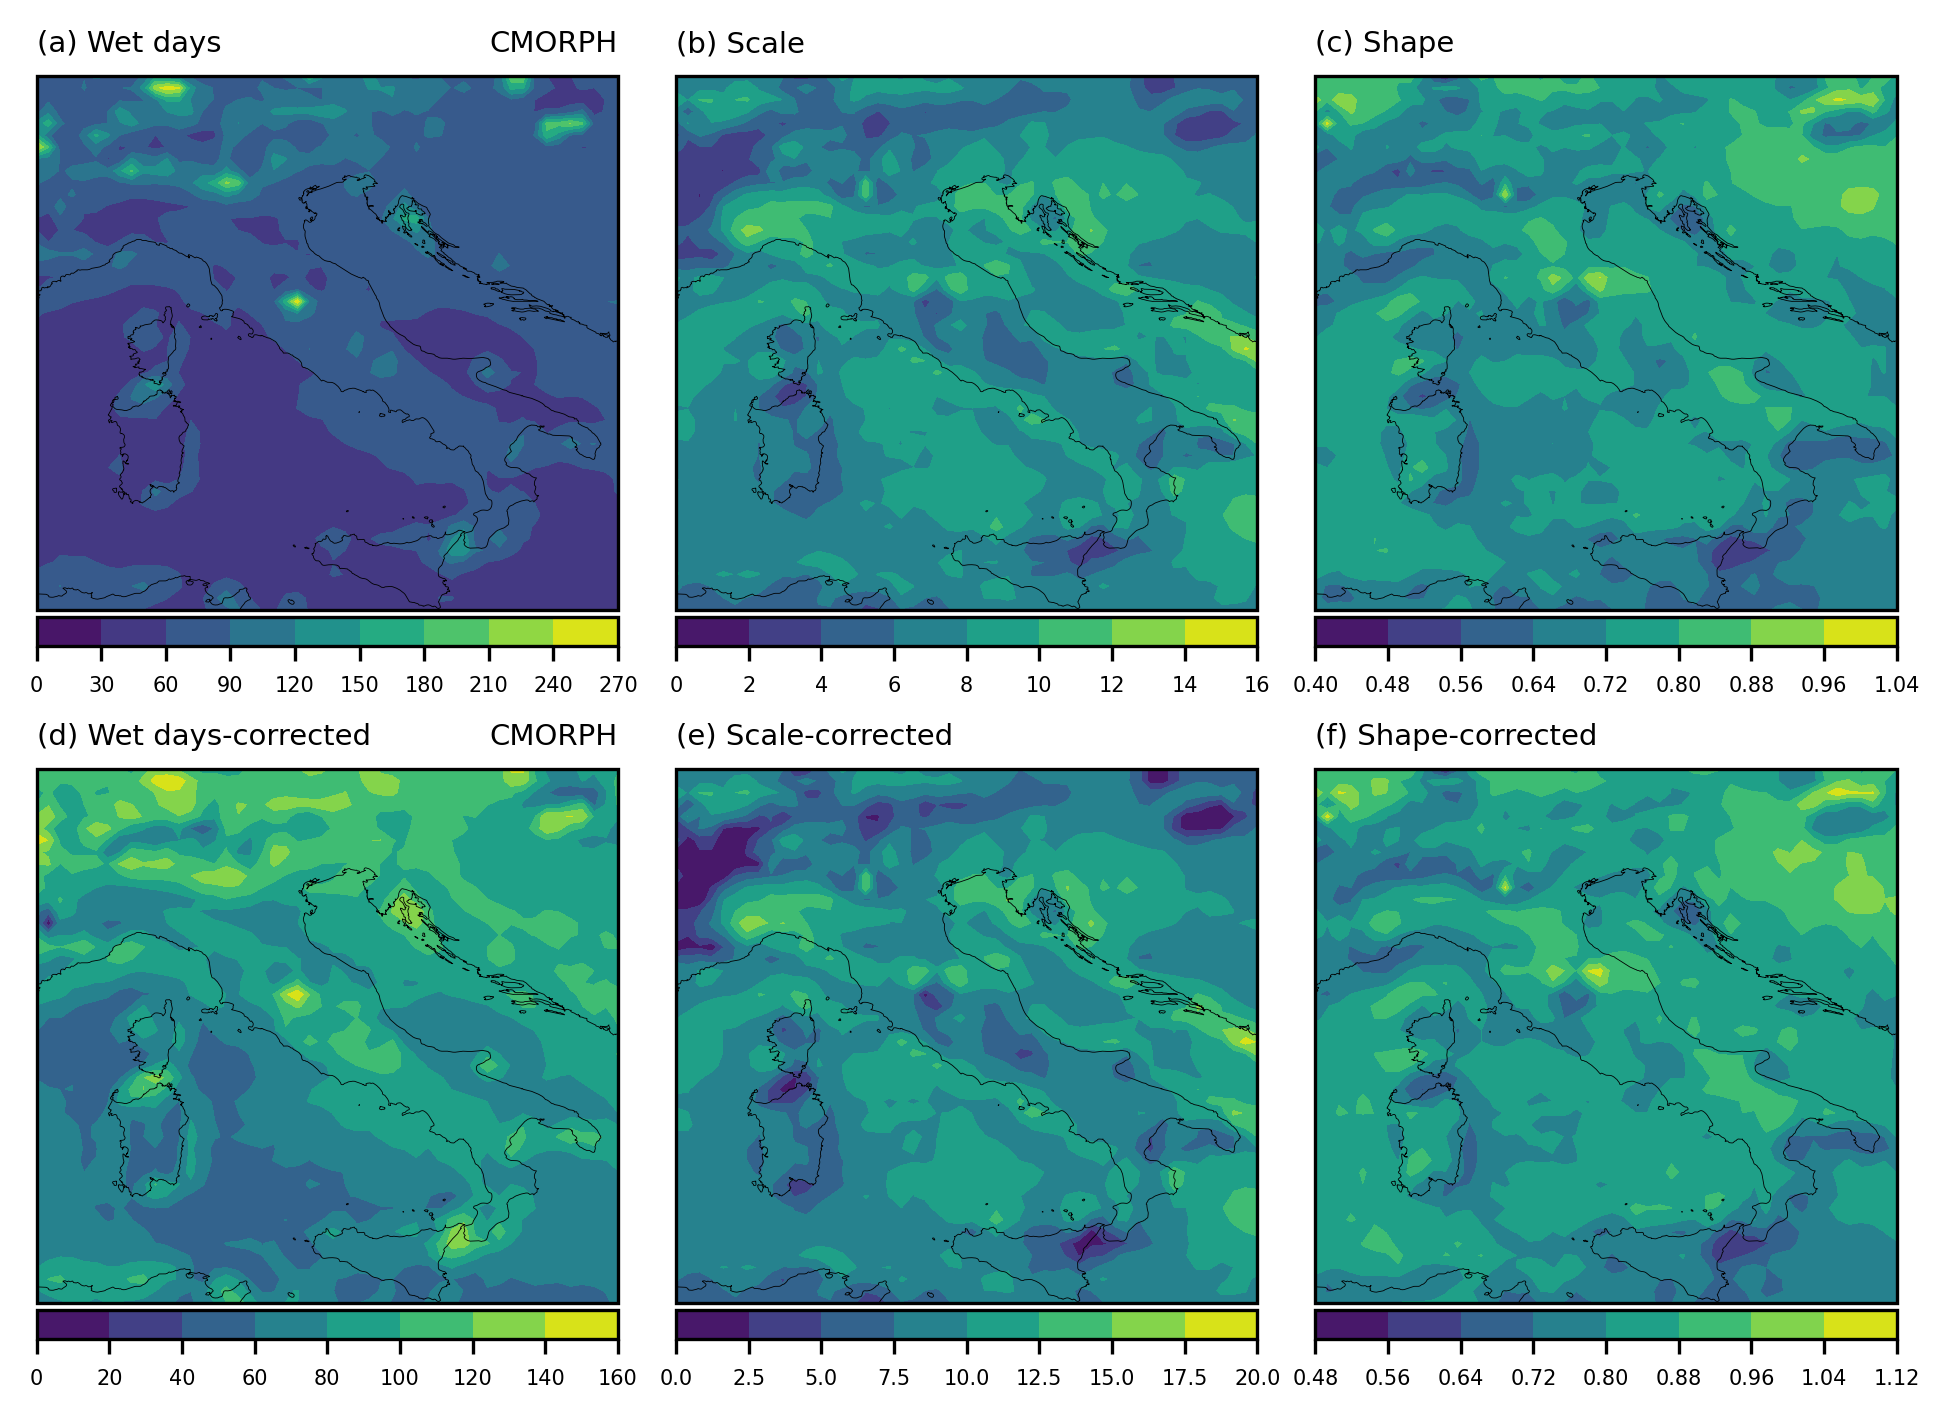

In [ ]:
levels_N = np.arange(20,260,20)
levels_C = np.arange(1,43,1)
levels_W = np.arange(0.5,1.6,0.1)

levels_N = None
levels_C = None
levels_W = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,6),dpi=300)
gs = gridspec.GridSpec(2,3)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(NYd,axis=0), levels=levels_N)

ax1.set_title(f'(a) Wet days', fontsize=7, loc='left')
ax1.set_title(f'{product}', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(CYd,axis=0), levels=levels_C)

ax1.set_title(f'(b) Scale', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(WYd,axis=0), levels=levels_W)

ax1.set_title(f'(c) Shape', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(NYd_corrected,axis=0), levels=levels_N)

ax1.set_title(f'(d) Wet days-corrected', fontsize=7, loc='left')
ax1.set_title(f'{product}', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(CYd_corrected,axis=0), levels=levels_C)

ax1.set_title(f'(e) Scale-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(WYd_corrected,axis=0), levels=levels_W)

ax1.set_title(f'(f) Shape-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [ ]:
Mevs_corrected = ART_down.pre_quantiles_array(
                        NYs_corrected, 
                        CYs_corrected, 
                        WYs_corrected, 
                        Tr, 
                        lats, lons,
                        1)

Mevd_corrected = ART_down.pre_quantiles_array(
                        NYd_corrected, 
                        CYd_corrected, 
                        WYd_corrected, 
                        Tr, 
                        lats, lons,
                        1)

In [ ]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_corrected),
        "CYs": (("year","lat","lon"), CYs_corrected),
        "WYs": (("year","lat","lon"), WYs_corrected),
        "NYd": (("year","lat","lon"), NYd_corrected),
        "CYd": (("year","lat","lon"), CYd_corrected),
        "WYd": (("year","lat","lon"), WYd_corrected),
        "Mev_d": (("Tr","lat","lon"), Mevd_corrected),
        "Mev_s": (("Tr","lat","lon"), Mevs_corrected),
    },
    coords={
        'year': Sat_year, 
        'lat': lats, 
        'lon': lons
    },
    attrs=dict(description=f"{product} Weibull parameters and MEV corrected applying ISIMIP_QM method using 80% of stations in Italy",)
)

DOWN_corrected.NYs.attrs["units"] = "# days"
DOWN_corrected.NYs.attrs["long_name"] = "Corrected Raw Number of Wet Days"
DOWN_corrected.NYs.attrs["origname"] = "Raw Wet Days"

DOWN_corrected.CYs.attrs["units"] = "nondimensional"
DOWN_corrected.CYs.attrs["long_name"] = "Corrected Raw Scale Parameter"
DOWN_corrected.CYs.attrs["origname"] = "Raw Scale"

DOWN_corrected.WYs.attrs["units"] = "nondimensional"
DOWN_corrected.WYs.attrs["long_name"] = "Corrected Raw Shape Parameter"
DOWN_corrected.WYs.attrs["origname"] = "Raw Shape"

DOWN_corrected.Mev_s.attrs["units"] = "mm/day"
DOWN_corrected.Mev_s.attrs["long_name"] = "Corrected Raw Extreme Quantiles"
DOWN_corrected.Mev_s.attrs["origname"] = "Raw Ext-Quant"

DOWN_corrected.NYd.attrs["units"] = "# days"
DOWN_corrected.NYd.attrs["long_name"] = "Corrected Downscaled Number of Wet Days"
DOWN_corrected.NYd.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYd.attrs["units"] = "nondimensional"
DOWN_corrected.CYd.attrs["long_name"] = "Corrected Downscaled Scale Parameter"
DOWN_corrected.CYd.attrs["origname"] = "Down Scale"

DOWN_corrected.WYd.attrs["units"] = "nondimensional"
DOWN_corrected.WYd.attrs["long_name"] = "Corrected Downscaled Shape Parameter"
DOWN_corrected.WYd.attrs["origname"] = "Down Shape"

DOWN_corrected.Mev_d.attrs["units"] = "mm/day"
DOWN_corrected.Mev_d.attrs["long_name"] = "Corrected Downscaled Extreme Quantiles"
DOWN_corrected.Mev_d.attrs["origname"] = "Down Ext-Quant"

DOWN_corrected.lat.attrs["units"] = "degrees_north"
DOWN_corrected.lat.attrs["long_name"] = "Latitude"

DOWN_corrected.lon.attrs["units"] = "degrees_east"
DOWN_corrected.lon.attrs["long_name"] = "Longitude"

In [ ]:
DOWN_corrected

<xarray.Dataset> Size: 3MB
Dimensions:  (year: 22, lat: 46, lon: 50, Tr: 6)
Coordinates:
  * lat      (lat) float32 184B 36.62 36.88 37.12 37.38 ... 47.38 47.62 47.88
  * lon      (lon) float32 200B 6.625 6.875 7.125 7.375 ... 18.38 18.62 18.88
  * year     (year) int64 176B 2002 2003 2004 2005 2006 ... 2020 2021 2022 2023
Dimensions without coordinates: Tr
Data variables:
    NYs      (year, lat, lon) float64 405kB 75.0 68.0 63.0 ... 102.0 107.0 109.0
    CYs      (year, lat, lon) float64 405kB 7.794 7.904 7.708 ... 10.35 12.35
    WYs      (year, lat, lon) float64 405kB 0.7201 0.7293 0.7045 ... 1.12 1.133
    NYd      (year, lat, lon) float64 405kB 81.0 74.0 71.0 ... 100.0 101.0 109.0
    CYd      (year, lat, lon) float64 405kB 6.938 6.997 6.75 ... 11.54 12.29
    WYd      (year, lat, lon) float64 405kB 0.6951 0.7024 0.6789 ... 1.145 1.072
    Mev_d    (Tr, lat, lon) float64 110kB 70.49 72.3 73.93 ... 92.0 96.36 108.1
    Mev_s    (Tr, lat, lon) float64 110kB 69.37 71.38 72.29 ... 97.81 106.8
Attributes:
    description:  CMORPH Weibull parameters and MEV corrected applying ISIMIP...

In [ ]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')

PRE_out = os.path.join(os.path.join(dir_base, '6_DOWN_BCorrected', dir_in.split('/')[-1].replace('_pearson',f'_pearson_{nameout}')))
print(f'Export as: {PRE_out}')
DOWN_corrected.to_netcdf(PRE_out)

Export as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/ITALY_DOWN_CMORPH_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc.nc


In [ ]:
playsound("../sound/HOMER_DOH.mp3")